<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Dataset-exploration" data-toc-modified-id="Dataset-exploration-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dataset exploration</a></span><ul class="toc-item"><li><span><a href="#Content-of-the-files" data-toc-modified-id="Content-of-the-files-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Content of the files</a></span></li><li><span><a href="#Importing-the-data" data-toc-modified-id="Importing-the-data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Importing the data</a></span></li></ul></li><li><span><a href="#Detecting-similar-books" data-toc-modified-id="Detecting-similar-books-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Detecting similar books</a></span><ul class="toc-item"><li><span><a href="#Using-titles-to-obtain-candidate-similars" data-toc-modified-id="Using-titles-to-obtain-candidate-similars-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Using titles to obtain candidate similars</a></span><ul class="toc-item"><li><span><a href="#Local-Sensitivity-Hashing" data-toc-modified-id="Local-Sensitivity-Hashing-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Local Sensitivity Hashing</a></span><ul class="toc-item"><li><span><a href="#The-minhash" data-toc-modified-id="The-minhash-3.1.1.1"><span class="toc-item-num">3.1.1.1&nbsp;&nbsp;</span>The <code>minhash</code></a></span></li><li><span><a href="#The-principle-of-LSH" data-toc-modified-id="The-principle-of-LSH-3.1.1.2"><span class="toc-item-num">3.1.1.2&nbsp;&nbsp;</span>The principle of LSH</a></span></li></ul></li><li><span><a href="#Using-LSH-to-work-on-titles" data-toc-modified-id="Using-LSH-to-work-on-titles-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Using LSH to work on titles</a></span></li><li><span><a href="#Inspecting-the-result-of-LSH-on-books-titles" data-toc-modified-id="Inspecting-the-result-of-LSH-on-books-titles-3.1.3"><span class="toc-item-num">3.1.3&nbsp;&nbsp;</span>Inspecting the result of LSH on books titles</a></span></li></ul></li><li><span><a href="#Enriching-our-dataset-using-Amazon-product-Advertising-API" data-toc-modified-id="Enriching-our-dataset-using-Amazon-product-Advertising-API-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Enriching our dataset using Amazon product Advertising API</a></span></li><li><span><a href="#Using-author-list-to-refine-candidate-similars" data-toc-modified-id="Using-author-list-to-refine-candidate-similars-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Using author list to refine candidate similars</a></span></li><li><span><a href="#Using-titles-to-obtain-our-final-set-of-similar-books" data-toc-modified-id="Using-titles-to-obtain-our-final-set-of-similar-books-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Using titles to obtain our final set of similar books</a></span></li><li><span><a href="#Saving-the-data-using-pickle-for-further-analysis" data-toc-modified-id="Saving-the-data-using-pickle-for-further-analysis-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Saving the data using pickle for further analysis</a></span></li></ul></li><li><span><a href="#Correlation-analysis" data-toc-modified-id="Correlation-analysis-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Correlation analysis</a></span></li><li><span><a href="#Herding-Effect-analysis" data-toc-modified-id="Herding-Effect-analysis-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Herding Effect analysis</a></span></li></ul></div>

In [32]:
%matplotlib inline
# To reload external scripts automatically
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sys
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Importing external files
from scripts.similarities import *
from scripts.amazon_api_interaction import *
from scripts.analysis import *
from scripts.data_import import *
from scripts.utils_project import *


pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In this notebook, we have tried to depict the full pipeline that we used for this project. It will not mention all the research that was done initially on a smaller dataset but those can be found in the ```research.ipynb```. Also note that most of the methods we use have been externalized to python files that can be found in ```scripts```.

# Introduction

_The goal of this project is to study the effect of the first review on an amazon product to subsequent reviews. This is also called the Herding effect._

Before we get started we wanted to explain our strategy. We have decided to focus on Amazon books as those make a great product to study the Herding effect as they are often available in different edition which do not modify the content.
1. The most challenging part was to **Identify similar books**. Indeed with a very large number of books it was complex to use pair wise comparison to do such task. Therefore we used Locality sensitive Hashing on the titles of the books (you can refer to the section for further explanations).
    * This method yields bins of candidate similar books that needs further refinements. While we first wanted to use the description of the book to find for example authors and other information, it turns out that most description are simply comments from journalists on the book and is therefore not that helpful. We decided to use **Amazon product advertising API** to obtain more metadata on the books that we found to be candidate similars.
    * Then **we used the authors of each book to refine candidate similars** where we tried to match the list of authors between two candidates by matching each author in a list to the author in the second book that had the least Levenstein distance. Once this matching was realized we look at the mean distance (the levenstein distance was transformed into a relative value to allow the comparison) and we consider valid two books whose mean relative levenstein distance is lower than 0.35. This phase allowed to delete books that had similar titles but not at all similar authors.
    * Finally we cleaned the titles from any unnecessary characters (parenthesis, colon, all lower case etc.) and decided to match two books if and only if the **symmetric difference of their normalized titles** is empty (which means that one of the set is entirely contained in the other).
2. Once we had those similar books, the real analysis can start. First of all we wanted to study the impact of reviews on the way user shop on the website (by using several metrics, trying for example to see the impact of average rating on the sales rank)
3. The very last step consisted in showing the Herding effect:
    * **Pre-analysis** of the obtained dataset was necessary in order to categorize the books into 6 categories (```HH,HM,HL,MM,ML,LL```) where ```H``` means that the first review of a book is High, ```M``` means that it is medium and ```L``` it is low. (you can refer to the section itself to see how we mapped those categories to the number of stars a book had)
    * We then plotted the average ratings for each groups depending on the fact that the book belong to the first or second letter of its category in order to see the **influence of the first review on the following**. Because of a quick convergence toward a similar value, we only analyzed the effect on the 5 first reviews.
    * As a final step we wanted to show the review average for each group on a **long term basis**. That is we wanted to see if on average the same book that had a first ```L``` rating has a lower review average in the long term than when it had a ```H``` first rating (comparing ```H``` in ```HL``` and ```L``` in ```HL```)

In [3]:
DATA_FOLDER = "../../Project-Data/"
META_FOLDER = DATA_FOLDER + "meta/"
REVIEWS_FOLDER = DATA_FOLDER + "reviews/"
CORE_FOLDER = DATA_FOLDER + "5_core/"
DUMP_FOLDER = DATA_FOLDER + "dump/"
CATEGORIES = ['Books','Movies_and_Tv','Electronics']
MAXCOUNT = -1
ANALYSIS_DATA_FOLDER = 'analysis_data/'

# Dataset exploration

## Content of the files

Because we have a lot of data we decided to first look at the content of the dataset in order to import into dataframes only the metadata that can be useful for our study. Note that we have three different types of file: **metadata**, **reviews** and **5-core** (which contains only reviews on products and reviewers that have at least 5 reviews).

The different columns of the **metadata** files are : 
* ```asin``` : the unique identifier of the object
* ```brand```
* ```categories``` : the categories of the object
* ```description``` : the description of the object
* ```imUrl```  : the link toward the images related to the object
* ```price```
* ```related``` : a list of objects that are related to this object
* ```salesRank``` 
* ```title```

The different columns of the **reviews** and **5-core** files are :
* ```asin``` : the unique identifier of the object
* ```helpful``` : a list of 2 integers [x,y], the helpfulness score is x/y votes
* ```overall``` : the rating of the object
* ```reviewText```
* ```reviewTime```
* ```reviewerID```
* ```reviewerName```
* ```summary ``` : the title of the review
* ```unixReviewTime``` : in Unix format

Therefore we keep only the column that are of interest for our task

In [6]:
meta_interesting_cols = ['asin', 'title', 'salesRank', 'description','imUrl']
review_interesting_cols = ['asin', 'overall', 'unixReviewTime']

## Importing the data

Working with large JSON would add a layer of complexity and therefore we imported the files to dataframes. A full pipeline has been made to do so. (NB: even-though the 5 core data was used for the exploratory phase we do not use it in the final study)

In [7]:
meta_books_path, review_books_path, core_book_path = get_paths(
    0, DATA_FOLDER, META_FOLDER, CORE_FOLDER, REVIEWS_FOLDER, CATEGORIES)
meta_books = import_interesting_cols(
    meta_books_path,
    DUMP_FOLDER,
    True,
    meta_interesting_cols,
    max_count=MAXCOUNT)
review_books = import_interesting_cols(
    review_books_path,
    DUMP_FOLDER,
    False,
    review_interesting_cols,
    max_count=MAXCOUNT)

Paths : 
	 meta = ../../Project-Data/meta/meta_Books.json
	 review = ../../Project-Data/reviews/reviews_Books.json
	 core_path = ../../Project-Data/5_core/Books.json
Retrieving from : ../../Project-Data/dump/meta_Books_asin_title_salesRank_description_imUrl_ALL
It took 00:00:05.051 to import the data.
Retrieving from : ../../Project-Data/dump/reviews_Books_asin_overall_unixReviewTime_ALL
It took 00:00:02.071 to import the data.


In [9]:
print("The meta_books dataframe has {} books and {} attributes".format(meta_books.shape[0],meta_books.shape[1]))
meta_books.head(1)

The meta_books dataframe has 2370585 books and 21 attributes


,asin,description,imUrl,"salesRank_Arts,_Crafts_&_Sewing",salesRank_Books,salesRank_Cell_Phones_&_Accessories,salesRank_Clothing,salesRank_Electronics,salesRank_Health_&_Personal_Care,salesRank_Home_&_Kitchen,...,salesRank_Jewelry,salesRank_Kitchen_&_Dining,salesRank_Movies_&_TV,salesRank_Music,salesRank_Musical_Instruments,salesRank_Office_Products,salesRank_Shoes,salesRank_Sports_&_Outdoors,salesRank_Toys_&_Games,title
0,0001048791,NaN,http://ecx.images-amazon.com/images/I/51MKP0T4...,NaN,6334800.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"The Crucible: Performed by Stuart Pankin, Jero..."


In [10]:
print("The review_books dataframe has {} reviews and {} attributes".format(review_books.shape[0],review_books.shape[1]))
review_books.head(1)

The review_books dataframe has 22507155 books and 3 attributes


,asin,overall,unixReviewTime
0,0000000116,4.0,2002-04-27


# Detecting similar books

We will now start to detect similar books. We have in previous exploratory discarded reviewers with less than 5 reviews and books with less than 5 reviews. While this latter does make sense for the Herding Effect analysis, the restriction on reviewers doesn't make much sense. We will therefore still keep the restriction on books of having at least 5 reviews.

In [11]:
print("In the full dataset we have {} books and  {} reviews".format(meta_books.shape[0],review_books.shape[0]))
books_reviews_count = review_books.groupby('asin').count().overall
asin_enough_reviews = list(books_reviews_count[books_reviews_count > 5].index)
print("We found {} books with enough reviews.".format(len(asin_enough_reviews)))

In the full dataset we have 2370585 books and  22507155 reviews
We found 625682 books with enough reviews.


Now that we have obtained the identifiers of the books with enough reviews we will keep only those in the ```meta_books``` dataframe.

In [12]:
meta_books_reduced = meta_books[meta_books['asin'].isin(asin_enough_reviews)]
print("Now the books dataset is composed of {} books".format(meta_books_reduced.shape[0]))

Now the books dataset is composed of 625682 books


Since we are working on large datasets we took the habit to serialize our intermediate work to reduce the running time of the code. We will serialize those in the ```../../Project-Data/dump_full/``` folder (you can refer to the ```README``` to observe the file architecture of the project). 

In [13]:
DUMP_FOLDER_FULL = DATA_FOLDER + 'dump_full/'

## Using titles to obtain candidate similars

We will explain quickly how LSH works

### Local Sensitivity Hashing

Based on this [article](http://dataconomy.com/2017/06/locality-sensitive-hashing-pydata/), and following the theory that can be read at the chapter 3.4 of [Mining of massive datasets by Leskovec, Rajaraman and Milliway](http://infolab.stanford.edu/~ullman/mmds/book.pdf) we will try to find similar books.

#### The ```minhash```

We need to detect near similar books in this large datasets. To do so we would need to compare each of the attribute of a given book with all the others which is extremely computationaly expensive. There we will use LSH. Right now the title and description of the book have variable length depending on the books. To perform LSH we would like to have a fixed length representation of the document without modifying the semantics of document similarity.
* first we introduce the principle of shingles. A shingle of 5-gram (hence we discard the last shingle as it only consists in the $<5$ last characters of the document) e.g. is a set of all possible 5-grams in the string. 

In [42]:
document = "Lorem Ipsum dolor sit amet"
shingles = get_shingles(document)
other_document = 'Lorem Ipsum dolor sit amet with some extra garbage'
other_shingles = get_shingles(other_document)
jaccard_dist(shingles,other_shingles)

0.4666666666666667

Each document will still have a different number of shingles depending on its length. Therefore we wish to represent it using a *fixed length representation*. We will present now a function ```minhash``` that has a collision probability that is exactly the jaccard similarity (based on this [document](http://infolab.stanford.edu/~ullman/mmds/ch3.pdf) and following this [repo](https://github.com/mattilyra/LSH/blob/master/examples/Introduction.ipynb)) . We explain this now :
1. Suppose that the following dataframe is the boolean variable corresponding to whether or not a shingle belongs to a document
2. the ```minhash``` of a document returns a random permutation of the rows and then the first row number it founds where the value is non 0.
    * therefore row 1 for doc 1
    * and row 0 for doc 2

In [43]:
ex_minhash = pd.DataFrame({'shingleID':[1,2,3,4,5,6],'doc1':[0,1,0,0,1,1],'doc2':[1,1,1,0,1,0]})
ex_minhash

,doc1,doc2,shingleID
0,0,1,1
1,1,1,2
2,0,1,3
3,0,0,4
4,1,1,5
5,1,0,6


But this is for this particular permutation, if we had another one like below then the ```minhash``` would return :
   * row 2 for doc1
   * row 1 for doc2

There are a lot of such permutations. Nevertheless we only care about having the same row for each document which mean we have collision of the ```minhash```. Therefore we have only two rows for which this happens : $\text{shingleID} \in \{2,5\}$. Hence the probability that the two doc have the same ```minhash``` (remmember that rows with two zeros do not count as they are not considered by ```minhash```) is the number of rows where both doc value is 1 divided by the number of rows where they are different : $\frac{2}{5}$

In [44]:
ex_minhash.sample(frac=1)

,doc1,doc2,shingleID
0,0,1,1
3,0,0,4
4,1,1,5
2,0,1,3
5,1,0,6
1,1,1,2


We can chose the length of the fingerprint that is returned by the ```minhash```, as we increase the length we get less variance from the random initialisation of the ```minhasher``` but this also greatly increases the memory usage.

#### The principle of LSH

In [45]:
from lsh import minhash
hasher = minhash.MinHasher(seeds=100, char_ngram=5)
fingerprint0 = hasher.fingerprint('Lorem Ipsum dolor sit amet'.encode('utf8'))
len(fingerprint0)

100

Therefore the hash of a document is composed of a given (```seeds```) number of ```minhashes```. We divide this number of ```minhashes``` into a given number of parts (e.g. 5). Since every single ```minhash``` has the jaccard similarity probability of collision then each of the 5 parts will have this probability as well. These parts represent the **locality** in the term LSH.

Then we hash the content of each part using a different hash function to obtain the *binID* that represents the **hashing** part of the method. Into each bin with *binID* we store the entire fingerprint of the document.

The idea is then that we compare documents that fall in the same bins : we will compare their fingerprint which is equivalent to looking at their Jaccard similarity between shingle sets. Since not all documents will fall into the same bins we have reduced the number of potential candidates.

Indeed we call :
* ```seeds``` :  number of ```minihashes``` that compose the fingerprint
* ```bands``` : the number of bins that we want to use

### Using LSH to work on titles

Using LSH (local sensitivity hashing) we will now try to find bins of candidate similars using the tiltes of the amazon products. Therefore we will keep in our dataframe only the books with an existing title and only the columns that can later be of interest.

In [15]:
meta_books_reduced  = meta_books_reduced [meta_books_reduced ['title'].notnull()]
meta_books_reduced = meta_books_reduced[['asin','title','description','imUrl']]
meta_books_reduced.head()

,asin,title,description,imUrl
10,0000913154,The Way Things Work: An Illustrated Encycloped...,NaN,http://ecx.images-amazon.com/images/I/7113akhD...
13,0001055178,Master Georgie,Beryl Bainbridge seems drawn to disaster. Firs...,http://ecx.images-amazon.com/images/I/51ZSC6TK...
25,0001018043,The Enchanted Horse,"Grade 3-6-In this fast-paced fantasy, a neglec...",NaN
34,0001473727,"The Greatest Book on ""Dispensational Truth"" in...",NaN,http://ecx.images-amazon.com/images/I/512M299K...
37,0000230022,The Simple Truths of Service: Inspired by John...,NaN,http://ecx.images-amazon.com/images/I/218uMkP0...


In [16]:
dump_path = DUMP_FOLDER_FULL
get_candidate_full = candidate_duplicates(meta_books_reduced,dump_path,['title'])

Retrieving from : ../../Project-Data/dump_full/candidate_dup_title_2_100_5_4
Found 15449 bins of possible duplicates.
With 36066 different books


*NB: the hashing used involves random number and therefore different run of the method ```candidate_duplicates``` might result in slightly different bins. This is one of the reason why we also serialize the candidates in order to always have the same data to deduct conclusion in further work*

In [50]:
meta_books_reduced.head()

,asin,title,description,imUrl
10,0000913154,The Way Things Work: An Illustrated Encycloped...,NaN,http://ecx.images-amazon.com/images/I/7113akhD...
13,0001055178,Master Georgie,Beryl Bainbridge seems drawn to disaster. Firs...,http://ecx.images-amazon.com/images/I/51ZSC6TK...
25,0001018043,The Enchanted Horse,"Grade 3-6-In this fast-paced fantasy, a neglec...",NaN
34,0001473727,"The Greatest Book on ""Dispensational Truth"" in...",NaN,http://ecx.images-amazon.com/images/I/512M299K...
37,0000230022,The Simple Truths of Service: Inspired by John...,NaN,http://ecx.images-amazon.com/images/I/218uMkP0...


### Inspecting the result of LSH on books titles

In [66]:
#Let's quickly oberve the type of data that we obtain
element_to_inspect = 66
similarity_keys = list(get_candidate_full.keys())
for t in get_titles(similarity_keys[element_to_inspect],get_candidate_full,meta_books_reduced):
    print(t)
    print("------")
for d in get_desc(similarity_keys[element_to_inspect],get_candidate_full,meta_books_reduced):
    print(d)
    print("------")
display_images(similarity_keys[element_to_inspect],get_candidate_full,meta_books_reduced)

Dreamer
------
Dreamer
------
Dreamer
------
At the center of National Book Award winner Charles Johnson's novelDreamerare three remarkable men: Martin Luther King Jr.; his aide, Matthew  Bishop, an African American philosophy student; and Chaym Smith, a man who is a dead  ringer for the civil rights leader. Not only does Smith resemble King, but he also shares  his intellectual voracity, widely read in both Eastern and Western philosophy, proficient  in Sanskrit and martial arts, and a talented painter. But where King is deeply spiritual,  Smith is a cynic; where King has the full force of his strong beliefs and his strong family  heritage, Smith has nothing but a lifetime of misfortune to shape his attitudes. When he  offers to become King's stand-in, Johnson creates an ideal situation in which to explore  issues long at the heart of the "race issue" in America: the inequality between black and  white, even between black and black.As the novel moves forward in time toward that fatefu

We can see that the books can greatly vary even though they have the same title. Also it seems hard to extract any meaningful data from their description therefore we need to use the Amazon API to try to get the data we are looking for.

## Enriching our dataset using Amazon product Advertising API

Because amazon API has strong limitations on the number of requests per account and the number of queries per seconds, we try to use it as efficiently as possible:
* we decided to limit our QPS (query per second) to 0.9 as the limit is 1 QPS. 
* whenever the API throttles our queries we wait a random amount of time before retrying (following a random variable with exponential distribution of parameter 0.1, as advised by Amazon).
* each query retrieves 10 books' details at a time.

This will allow us to get many more details of our books : ```authors, publisher, ISBN, sales_rank_updated, binding, edition, release_date```. We might not need all of them but because of the restriction of the API we decided to obtain as much as possible for each book should we decide to use it later on.

In [17]:
amazon_access_file_path = DUMP_FOLDER + "amazon_access_epfl_new"
book_only_candidates,failed = fill_in_with_details(meta_books_reduced,amazon_access_file_path,get_candidate_full,DUMP_FOLDER_FULL)
book_only_candidates.head(2)

Retrieving from : 
	../../Project-Data/dump_full/book_only_candidates_with_details
	../../Project-Data/dump_full/api_failed 
It took 00:00:00.181 to get the data.


,asin,title,description,imUrl,authors,publisher,ISBN,sales_rank_updated,binding,edition,release_date
0,0001473727,"The Greatest Book on ""Dispensational Truth"" in...",NaN,http://ecx.images-amazon.com/images/I/512M299K...,[C. Larkin],Titles distributed by Christian Art Distributors,0001473727,837246,Relié,None,None
1,0001472933,The Book of Daniel,NaN,http://ecx.images-amazon.com/images/I/414KH1FP...,[],Rev Clarence Larkin Estate,0001472933,1569511,Relié,None,None


Some book ASIN might not have been successfully retrieved for numerous reasons, one of which might be that the object isn't sold anymore. We saved such failed ASIN in the ```failed``` list.

In [19]:
print("book_only_candidates.shape = ",book_only_candidates.shape)
print("{} have failed".format(len(failed)))

book_only_candidates.shape =  (36066, 11)
550 have failed


## Using author list to refine candidate similars

Because the matching will now use authors of each books, we will eliminate from our dataset the books for which no authors was found (in the case where the API couldn't retrieve the details of the book using the ASIN) but also in the case where it is an empty list (the API call was successful but no author was returned.

In [20]:
book_only_candidates = book_only_candidates[book_only_candidates['authors'].notnull()]
book_only_candidates = book_only_candidates[book_only_candidates['authors'].apply(lambda x:len(x)>0)]
print("This leaves us with {} books to work with".format(book_only_candidates.shape[0]))

This leaves us with 33337 books to work with


Now we also need to keep in our dictionnary ```get_candidate_full```, obtained from LSH, only the books that have an author list that allow us to match them.

In [21]:
compliant_asins = set(book_only_candidates['asin'])
similar_sets = [set(get_candidate_full[k]+[k]) for k in get_candidate_full.keys()]
similar_sets_compliant=[]
for s in similar_sets:
    inter = s & compliant_asins
    if(len(inter)>1):
        similar_sets_compliant.append(inter)
print("We now have {} bins of similar books to work with".format(len(similar_sets_compliant)))

# And we put it back into a dictionnary
similars = [sorted(list(s)) for s in similar_sets_compliant]
get_candidate = {elements[0]:elements[1:] for elements in similars}
book_only_candidates = book_only_candidates.set_index('asin')

We now have 13913 bins of similar books to work with


We saw examples where the authors list between two books were very similar but names were written differently, therefore we need to check that some typos are not in the names of authors : (e.g. ```{'Ian MacNeill', 'SportMed BC'}{'Ian MacNeil'}``` where MacNeil is written with two 'l' in the first book but only one in the second one). Therefore we will first clean the names (remove accents, nomalize it to lower case) and then try to match then using the Levenstein distance, we match two author list if the mean difference between authors is less that 0.35 (NB: this is a relative distance in order to be able to compare title with different length). 

See the function ```check_name_similarity``` in the ```utils.py``` files for more details on how this is done.

In [22]:
book_only_candidates['authors'] = book_only_candidates['authors'].apply(clean_name_in_dataframe)
similars = get_similar_authors(book_only_candidates,get_candidate,0.35)
print("We have found {} bins of candidate similars".format(len(similars.keys())))

We have found 5987 bins of candidate similars


We can see that we have some unwanted behaviour of the author matching function. Indeed because we want to avoid at all cost false positives we have some matching that could trivially be done by humans : 'sir arthur conan doyle' and 'a conan doyle' are considered but should be considered similar. We decided to leave the task of refining the matching to a later study and possibly to a reader that would like to extend our work.

## Using titles to obtain our final set of similar books

Now we might still have problems with books that have highly similar titles and authors but aren't identical. This could be explained by :
* Different Tomes : same title but different number
* educational books that have identical titles except for what they teach
* simply typos or very small differences 
* many other examples 

Example of books that are not similar:
```
Adobe Dreamweaver CS3 Classroom in a Book['adobe creative team']
Adobe Dreamweaver CS4 Classroom in a Book['adobe creative team']
Adobe Dreamweaver CS5 Classroom in a Book['adobe creative team']
Adobe Dreamweaver CS6 Classroom in a Book['adobe creative team']
----------------------------------------------------------------
Promethea, Book 3['alan moore']
Promethea, Book 5['alan moore']
Promethea, Book 1['alan moore', 'j. h. williams', 'mick gray']

```

Example of books that should be considered similar:
``` 
'Light Science and Magic: An Introduction to Photographic Lighting'['fil hunter', 'paul fuqua', 'steven biver']
'Light: Science and Magic: An Introduction to Photographic Lighting'['fil hunter', 'steven biver', 'paul fuqua']
```

We will therefore also need to see if the title are similar enough. **We want to avoid false positive as much as possible. We are sure that we could go even further with matching names but prefer to be conservative here**. Therefore we only try to normalize as much as possible the titles and see if then the titles taken as sets have an empty symmetric difference.

In [23]:
book_only_candidates['title'] = book_only_candidates['title'].apply(clean_title)
very_similars = get_similar_titles(book_only_candidates,similars)
print("We have found {} bins of very similar books.".format(len(very_similars.keys())))
very_similar_ASIN = list(very_similars.keys())
very_similar_ASIN += [item for sublist in list(very_similars.values()) for item in sublist]
print("We have {} asins for products that have at least one similar product.".format(len(very_similar_ASIN)))

We have found 3050 bins of very similar books.
We have 6410 asins for products that have at least one similar product.


Using the ```observational_print``` argument of ```get_similar_titles``` one can observe how our function is quite conservative and why:

An example where the titles were not matched, providing there difference:
```
'college mathematics for business economics life sciences and social sciences 12th edition barnett'
'finite mathematics for business economics life sciences and social sciences 12th edition barnett'
	 --->'college','finite'
```
and another one
```
'mastering the nikon d700'
'mastering the nikon d600'
	 --->'d700','d600
```

We can see what titles are going to be matched : 
*What is interesting here is that the last title contains a repetition of the title inside parenthesis, after the cleaning, we will have removed the parenthesis and will check if the symmetric difference in terms of set of words is empty.*
```
"Jeff Herman's Guide to Book Publishers, Editors & Literary Agents: Who They Are! What They Want! and How to Win Them Over!",
"Jeff Herman's Guide to Book Publishers, Editors and Literary Agents : Who They Are! What They Want! How to Win Them Over!",
"Jeff Herman's Guide to Book Publishers, Editors, and Literary Agents: Who They Are! What They Want! How to Win Them Over! (Jeff Herman's Guide to Book Publishers, Editors, & Literary Agents)"
```
*or this second example where a ':' has been replace with a ';'*
```
'Hawaii the Big Island Revealed: The Ultimate Guidebook',
'Hawaii The Big Island Revealed; The Ultimate Guidebook',
```


While we know that we might be missing a lot of titles, we much rather have less title and 0 false positives than to risk having false positives.

## Saving the data using pickle for further analysis
Now that we have obtained the dataset that we wish to use to conduct our analysis it is time to save it locally to avoid long and repetitive operations while we do the analysis.

In [26]:
ANALYSIS_DATA_FOLDER = 'analysis_data/'
books_df_path = ANALYSIS_DATA_FOLDER + 'books_full'
review_books_df_path = ANALYSIS_DATA_FOLDER + 'review_books_full'
very_similars_path = ANALYSIS_DATA_FOLDER + 'very_similars_full'

paths = [books_df_path,review_books_df_path,very_similars_path]

In [39]:
retrieved = []
# Get the file from the dump
if(all(os.path.isfile(p) for p in paths)):
    # We check if the files already exist
    print("Retrieving from :")
    for i,p in enumerate(paths):
        print("\t{}".format(p))
        if(i<2):
            df = pd.read_pickle(p)
            retrieved.append(df)
        else:
            with open(p, 'rb') as handle:
                very_similars = pickle.load(handle)
                retrieved.append(very_similars)
else:
    # Otherwise we create them
    book_only_candidates.loc[very_similar_ASIN].to_pickle(ANALYSIS_DATA_FOLDER + 'books_full')
    review_books.query('asin in @very_similar_ASIN').to_pickle(ANALYSIS_DATA_FOLDER + 'review_books_full')
    with open(ANALYSIS_DATA_FOLDER + 'very_similars_full', 'wb') as handle:
        pickle.dump(very_similars, handle, protocol=pickle.HIGHEST_PROTOCOL)

books_df,review_books_df,very_similars=retrieved
print("We have retrieved:\n\tbooks_df with shape: {}\n\treview_books_df with shape: {}\n\tvery_similars with length: {}".format(books_df.shape,review_books_df.shape,len(very_similars)))

Retrieving from :
	analysis_data/books_full
	analysis_data/review_books_full
	analysis_data/very_similars_full
We have retrieved:
	books_df with shape: (6410, 10)
	review_books_df with shape: (361389, 3)
	very_similars with length: 3050


# Correlation analysis

# Herding Effect analysis

Now that we have seen that it is hard to show conclusive results regarding reviews and other product characteristics (price, sales rank, and other correlation analysis). We want to study how the first review influence the others or the so called "herding effect".

In this analysis we will need the books matched from the first step. We realised this Herding Effect analysis in two steps. We first validated our hypothesis of herding effect on a small dataset of arround 880 pair of books and then we took a step further and tried to validate it again on a bigger dataset (3720 pairs of books). Only the second step is present in this milestone as similar but more complete results are observable on the larger dataset.

In [8]:
# load the data from the matching step
books_df = pd.read_pickle(ANALYSIS_DATA_FOLDER + 'books_full')
review_books_df = pd.read_pickle(ANALYSIS_DATA_FOLDER + 'review_books_full')
with open(ANALYSIS_DATA_FOLDER + 'very_similars_full', 'rb') as handle:
    very_similars = pickle.load(handle)

## Pre-analysis

Before going any further in the herding effect analysis, this very first step is focused on gathering the data from the matching and categorize each pair of similar book into different categories that are going to be used in our futur analysis.

As a starting point, we will add a first_review_overall column in our books_df. It will contain the first rating of this particular book. And will help us at many occasion in our analysis.

In [9]:
# we add to each books his first review overall rating
books_df['first_review_overall'] = books_df.apply(lambda x: return_first_review_overall(x, review_books_df), 1)

A second required and important step was to create a "matching_df that" contains every possible pair matched from previous matching step with every possible combinations.

In [10]:
# create a flat matching DF with every unique possible pair including combination
matching_df = pd.DataFrame(columns=['asin_1', 'asin_2'])
for asin, matched_asin in very_similars.items():
    total_matched_asin = matched_asin + [asin]
    for i, asin in enumerate(total_matched_asin):
        for j in range(i+1, len(total_matched_asin)):
            matching_df = matching_df.append({'asin_1': asin, 'asin_2': total_matched_asin[j]}, ignore_index=True)
matching_df.head()

,asin_1,asin_2
0,076452562X,0470068647
1,0261103288,1598878980
2,0261103288,0261102664
3,1598878980,0261102664
4,1574323539,1574324691


Then for the needs of our analysis, we need to split our data in different categories according to their first review overall. Some will be categorized as High first review (H), some will be categorized as Low first review (L). We also tried different combination of H and L with different treshold. We also introduce a (M) level or medium first review rating.

#### H/M/L Categorization

By trying different combination during milestone 2 and looking at the repartition of the ratings in the second part of this notebook. Best results were found with a High first review (H) set to a first review being equal to 5, a Medium first review (M) set to a first review being equal to 4 and finally a Low first review (L) set to a first review being in a range from 1 to 3.

Again for clarity we decided to display for this milestone only the final working category repartition and discard the other attempts shown in milestone 2 if needed.

In [11]:
matching_df['type'] = matching_df.apply(lambda x: 
                                        categorize_pair(x, return_category_from_value_HML, books_df), axis=1)
matching_df.groupby('type').count()

,asin_1,asin_2
type,,
HH,1695,1695
HL,368,368
HM,375,375
LH,369,369
LL,164,164
LM,134,134
MH,393,393
ML,106,106
MM,116,116


And before drawing any conclusion let's aggregate similair pair such as LH and HL.

In [12]:
# aggregate LH and HL by swaping the value in the dataframe
matching_df[matching_df.type == "LH"] = matching_df.query('type == "LH"').reindex(columns=['asin_2', 'asin_1', 'type'])
matching_df.loc[matching_df.type == "LH", "type"] = "HL"

# aggregate MH and HM by swaping the value in the dataframe
matching_df[matching_df.type == "MH"] = matching_df.query('type == "MH"').reindex(columns=['asin_2', 'asin_1', 'type'])
matching_df.loc[matching_df.type == "MH", "type"] = "HM"

# aggregate LM and LM by swaping the value in the dataframe
matching_df[matching_df.type == "LM"] = matching_df.query('type == "LM"').reindex(columns=['asin_2', 'asin_1', 'type'])
matching_df.loc[matching_df.type == "LM", "type"] = "ML"

matching_df.groupby('type').count()

,asin_1,asin_2
type,,
HH,1695,1695
HL,737,737
HM,768,768
LL,164,164
ML,240,240
MM,116,116


Now we observe that interestingly enough we have a significant part of our dataset falling into the HH category. This is not surpring when we look at the repartion of the rating from part 2. 

The other important thing to note here is that we now have enough data to explore almost every category. Indeed in our small scale analysis of milestone 2 we had meaningfull insight for categories with around 150 data poinst. Here we can see that every category is above that, except the MM one with only 116 data. This observation is good for our analysis as it means that it will allow us to study and validate our hypothesis on more category this time than during milestone 2.

### Herding Effect Analysis

#### Introduction

The herding effect is observed when rating a product or a customer is biased to follow other customers's previous rating on the same product. In this study of the Herding Effect on Amazon reviews dedicated to the book category, we are going to focus mostly on how the first review on 2 similar products can influence latter reviews.

#### A first example

To better understand what is the herding effect and what it could mean on the review of a product, let's draw and example of such a case. After matching each pair of product together in the previous step, and assign some categories to them ("HH", "HM", "HL", "MM", "ML"). We are going to choose a matching pair with the highest possible difference in order to be able to clearly see the effect (i.e. in the "HL" category).

In [13]:
highest_diff = matching_df.query('type == "HL"').apply(lambda x: find_highest_diff(x['asin_2'], books_df), axis=1)
highest_diff.sum()

243

We find that there is 243 cases in our dataset with 2 very similar products having in one case a first rating of 1 star against a first rating of 5 stars. We take as example one of such a case to demonstrate the Herding Effect.

In [22]:
# take one of the matches as example
match = matching_df.query('type == "HL"')[highest_diff].iloc[236]
asin_1 = match.asin_1
asin_2 = match.asin_2

# observe that they are indeed very similar books
interesting_cols = ['title', 'description', 'authors', 'edition', 'publisher']
for col in interesting_cols:
    print('Book 1 - {}: {}'.format(col, books_df.loc[asin_1][col]))
    print('Book 2 - {}: {}'.format(col, books_df.loc[asin_2][col]))
    print()

Book 1 - title: untie the strong woman blessed mothers immaculate love for the wild soul
Book 2 - title: untie the strong woman blessed mothers immaculate love for the wild soul

Book 1 - description: (Starred Review) In the first work by poet and psychoanalyst Estés (Women Who Run with Wolves) in a decade, this brilliant treatment is much larger than the sum of its parts. Estés's understanding of Our Holy Lady ("she wears a thousand names") is disturbing and enlightening; she presents a figure who reflects and elevates the essential and inherent qualities of humanity. Through sacred traditions, personal stories, prayers, and images, Estés makes visible the ancient and modern fiercely loving force of the Divine feminine-the Compassionate Mother. "The ultimate Mother Who Gave Birth to Love... bends to tend to the needful soul," Estés writes. Like the traditional prayer Memorare, through the technology of mind and heart, this book calls readers to awaken with full consciousness "to Her w

As we can confirm above in both case we are talking about the same book: untie the strong woman blessed mothers immaculate love for the wild soul from Clarissa Pinkola Estes with the same title, same description, same brands... However in one case (book 1) the first review rating is 5 and in the other case the first review is 1. This is the ideal case (Book 2) to observe the herding effect and see the influence of the first review on the following's.

And as we know a picture is worth a thousand words, in the next step, we are going to draw 2 graphs that seems to show the herding effect behaviour on this particular book example.

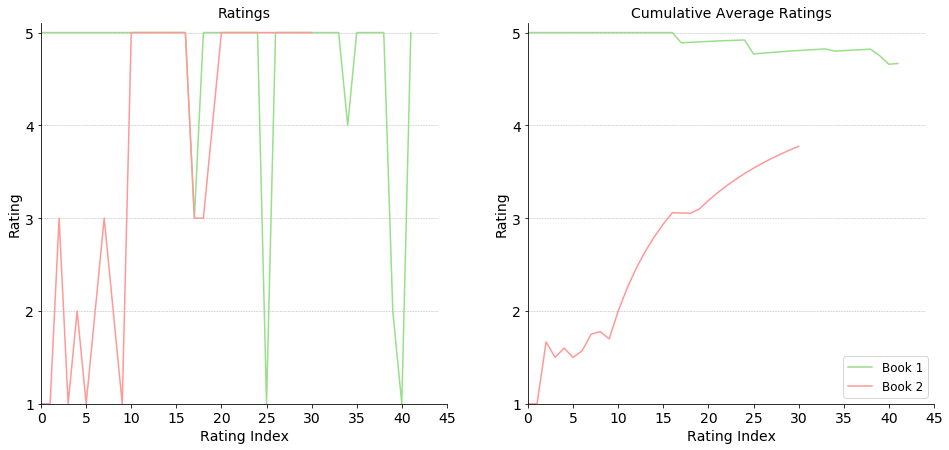

In [23]:
data_1 = review_books_df.query('asin == @asin_1').sort_values('unixReviewTime')
data_2 = review_books_df.query('asin == @asin_2').sort_values('unixReviewTime')
plot_example_rat_and_cumrat_subplots(data_1, data_2)

On these graphs we observe two things.

First in this particular example, the cumulative average ratings seems to converge toward a similar value in both books. This is an important observation because without that we could simply not tell wether the herding effect had influence on the reviews or not. Furthermore we could not observe how many reviews after a bad review the herding effect had still some kind of impact.

The second observation is that on Book 2, following the first bad reviews, the 10 following reviews seems to be surprinsingly low when we compare with Book 1. This can be confirm on the cumulative average ratings with an average staying low for the 10 first reviews. We could interpret this as the sign of the herding effect that did last during approximately 10 reviews.

This example was very convenient as it had a huge difference between the first review of the two very similar books and a cumulative average rating converging toward a similar value. It helped us understand better what is the herding effect and what kind of influence in could have on the following reviews. Now from this nic example, let's try to generalize our theory and see if we can observe the herding effect on a larger number of data.

#### Generalization

We are going to study here every groups independtly HH, MM, LL, HM, HL and ML. Since we now have enough data to draw a generalization on the herding effect for each of these groups. To measure the herding effect on our dataset, we are going to compare the i-th rating between similar products in each group respectively. If we observe a positive difference between these values, it would supports the hypothesis of a causal link between the first rating and the following ones. We should also be able to see until what index this effect can be observed.

We use HH, MM and LL as a testing groups in which we should not have any influence from the herding effect, HM and ML should have a moderated impact and finally the most interesting category should be HL in which we should really see the impact of the herding effect.

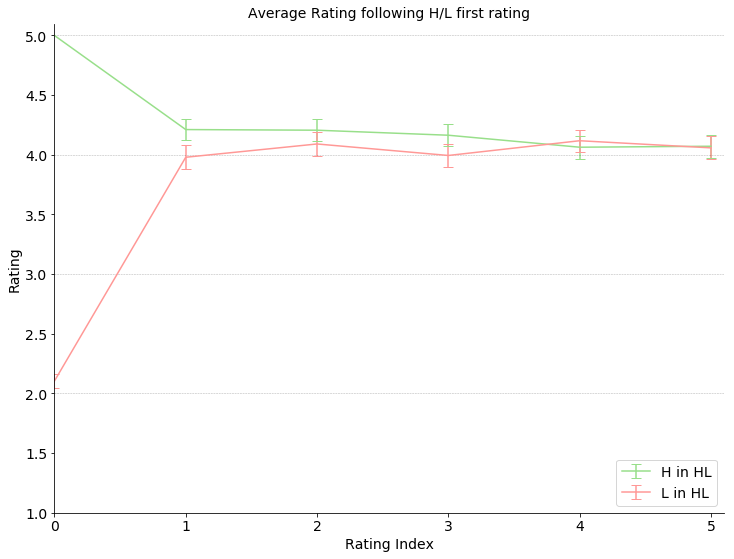

In [24]:
# find for each books in each pair of type HL the 5 first reviews
result = matching_df.query('type == "HL"').apply(lambda x: find_n_reviews(x, 5, review_books_df), 1)

# create 2 df based on the result of our functions with the 5 reviews as columns
H_in_HL_df = pd.DataFrame([x[0] for x in result])
L_in_HL_df = pd.DataFrame([x[1] for x in result])

# compute the interesting stats for each reviews (mean and 95% confidence interval)
H_in_HL_stats = compute_stats_on_reviews_df(H_in_HL_df)
L_in_HL_stats = compute_stats_on_reviews_df(L_in_HL_df)

# plot the result in a nice errorbar plot
plot_stats_bar_plot('Average Rating following H/L first rating',
                    H_in_HL_stats, light_green, 'H in HL', L_in_HL_stats, light_red, 'L in HL')

As we can see just above, the results are mitigate we can observe that the 2-3 reviews after a bad first reviews tends to be in average lower than when the first review is good. However after that it seems that everything come back to normal and the herding effect has no longer impact. Finally the reviews tends to converge to a same average value which is good given the fact that they are supposed to be similar books afterall.

Having now more than 700 datapoints at hand to confirm our theory from milestone 2 and observing quiet similar result is encouraging for the validity of our theory regarding the herding effect. 

Now let's see if we can observe the effect a little more and look only at the most extreme difference in first rating (1 and 5 stars). In our first analysis we had very volatile results with a very high variance as we had not a lot of data for this very specific case (only 43) but now since we have 243 results we should be able to observe better results.

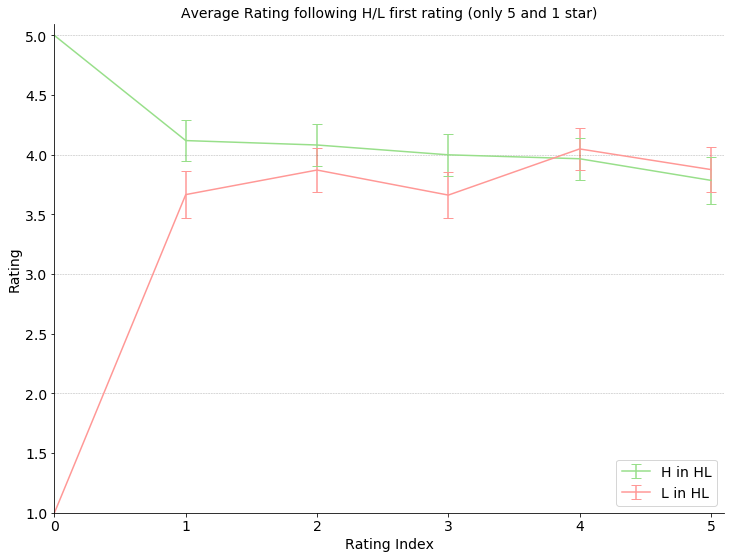

In [25]:
# herding effect on 1-5star
result = matching_df.query('type == "HL"')[highest_diff].apply(lambda x: find_n_reviews(x, 5, review_books_df), 1)

# create 2 df based on the result of our functions with the 5 reviews as columns
H_in_HL_df = pd.DataFrame([x[0] for x in result])
L_in_HL_df = pd.DataFrame([x[1] for x in result])

# compute the interesting stats for each reviews
H_in_HL_stats = compute_stats_on_reviews_df(H_in_HL_df)
L_in_HL_stats = compute_stats_on_reviews_df(L_in_HL_df)

# plot the result in a nice plot
plot_stats_bar_plot('Average Rating following H/L first rating (only 5 and 1 star)',
                    H_in_HL_stats, light_green, 'H in HL', L_in_HL_stats, light_red, 'L in HL')

Interestingly enough, we see a much higher difference on the second review that seems to converge toward a similar value. It's also worth noting that the final value seems to be significantly lower than in the previous case. However we also observe that it still takes arround 3 to 4 review before coming back to a similar converging value.

To confirm our result and hypothesis we can now check the difference between what we have just above and what we get performing the same pipeline on the different groups (HH, HM..). In the HH case, we expect to have no herding effect at all, and converging results right from the beginning. Regarding the HM case, we would expect to see the same effect as above but this time lowered.

Let's once more confirm our theory on the HH category. This time on many more data as the HH category regroup no less than 1695 pairs of books this time.

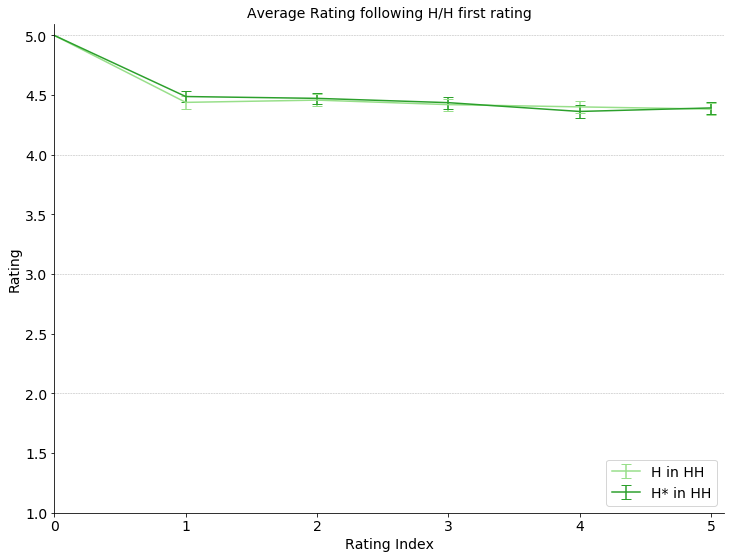

In [26]:
# herding effect on HH
result = matching_df.query('type == "HH"').apply(lambda x: find_n_reviews(x, 5, review_books_df), 1)

# create 2 df based on the result of our functions with the 5 reviews as columns
H_in_HH_df = pd.DataFrame([x[0] for x in result])
Hstar_in_HH_df = pd.DataFrame([x[1] for x in result])

# compute the interesting stats for each reviews
H_in_HH_stats = compute_stats_on_reviews_df(H_in_HH_df)
Hstar_in_HH_stats = compute_stats_on_reviews_df(Hstar_in_HH_df)

plot_stats_bar_plot('Average Rating following H/H first rating',
                    H_in_HH_stats, light_green, 'H in HH', Hstar_in_HH_stats, strong_green, 'H* in HH')

And this is indeed a confirmation of our findings. We can clearly see here that when 2 books start with a high review, all the following reviews tends to be similar which confirm that the difference might be due to the first review being different. (herding effect)

#### Deeper Analysis of the left over categories from MS2 analysis

In the smaller scale analysis, we were not able to study some groups such as LL and MM as the number value we had at our disposal was to small. Now that we have more data at hand, it could be interesting to study these groups as well. Studying MM and LL should confirm our hypothesis on the herding effect, while we would expect ML and HM to show slightly less impact of the herding effect as the difference between their first review would be smaller.

This time again, one should be carefull with the results regarding the smaller group such as LL and MM should be as the number of data might be to small to draw significant conclusion.

#### confirmation of the herding effect on MM and LL

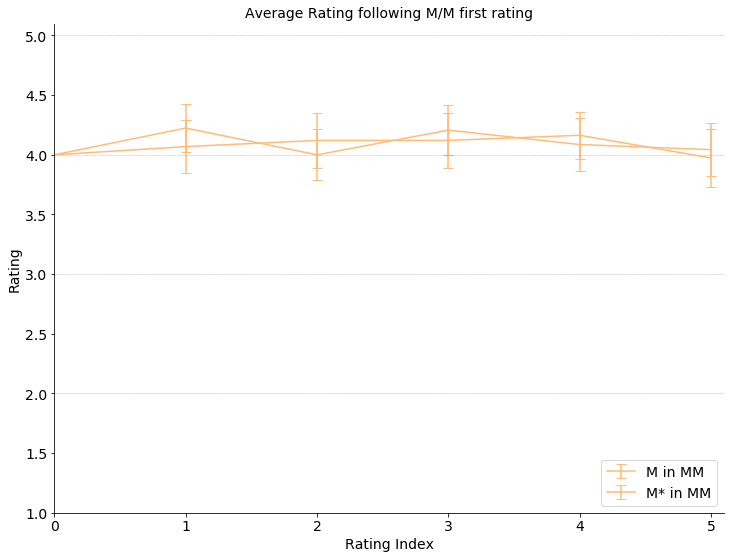

In [27]:
# herding effect on MM
result = matching_df.query('type == "MM"').apply(lambda x: find_n_reviews(x, 5, review_books_df), 1)

# create 2 df based on the result of our functions with the 5 reviews as columns
M_in_MM_df = pd.DataFrame([x[0] for x in result])
Mstar_in_MM_df = pd.DataFrame([x[1] for x in result])

# compute the interesting stats for each reviews
M_in_MM_stats = compute_stats_on_reviews_df(M_in_MM_df)
Mstar_in_MM_stats = compute_stats_on_reviews_df(Mstar_in_MM_df)

plot_stats_bar_plot('Average Rating following M/M first rating',
                    M_in_MM_stats, orange, 'M in MM', Mstar_in_MM_stats, orange, 'M* in MM')

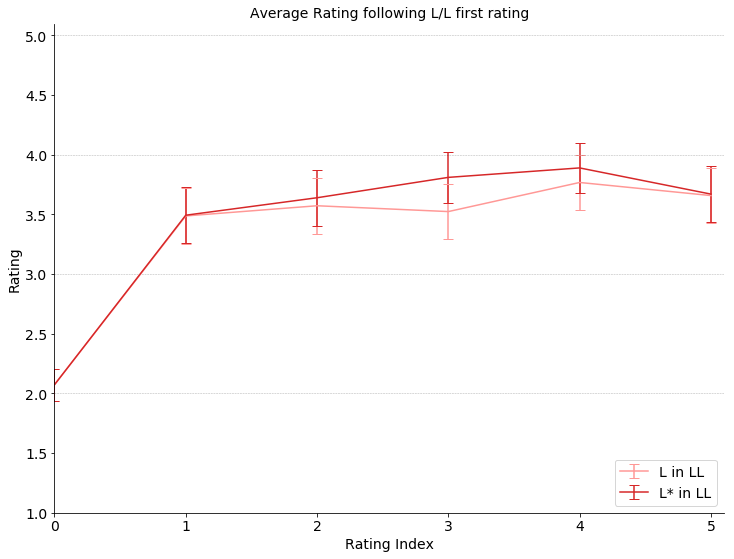

In [28]:
# herding effect on LL
result = matching_df.query('type == "LL"').apply(lambda x: find_n_reviews(x, 5, review_books_df), 1)

# create 2 df based on the result of our functions with the 5 reviews as columns
L_in_LL_df = pd.DataFrame([x[0] for x in result])
Lstar_in_LL_df = pd.DataFrame([x[1] for x in result])

# compute the interesting stats for each reviews
L_in_LL_stats = compute_stats_on_reviews_df(L_in_LL_df)
Lstar_in_LL_stats = compute_stats_on_reviews_df(Lstar_in_LL_df)

plot_stats_bar_plot('Average Rating following L/L first rating',
                    L_in_LL_stats, light_red, 'L in LL', Lstar_in_LL_stats, strong_red, 'L* in LL')

Considering that MM and LL represent respectively only 116 and 164 pairs of data we observe a high variability in the results. However we can clearly see by taking off the noise coming from the low number of data that the rating after similar first rating is also similar (no herding effect). This is what we observe better and at a larger scale on the HH group just above.

#### confirmation of a smaller herding effect on HM and ML

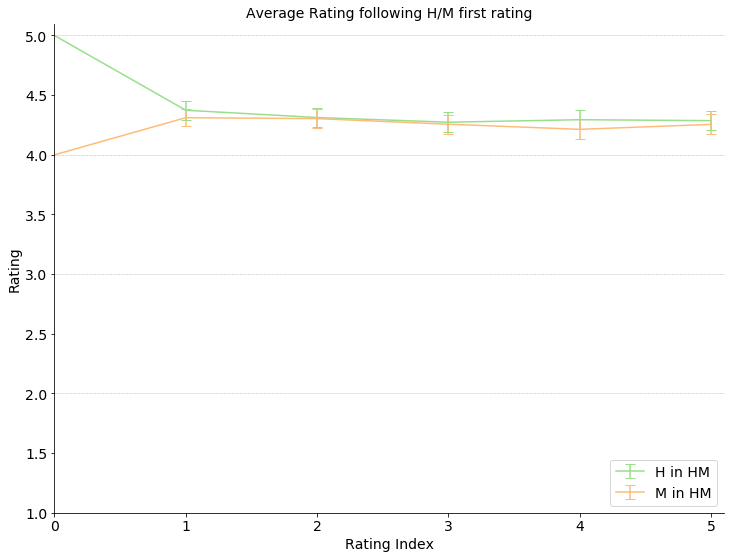

In [29]:
# herding effect on HM
result = matching_df.query('type == "HM"').apply(lambda x: find_n_reviews(x, 5, review_books_df), 1)

# create 2 5reviews df based on the result of our functions
H_in_HM_df = pd.DataFrame([x[0] for x in result])
M_in_HM_df = pd.DataFrame([x[1] for x in result])

# compute the interesting stats for each reviews
H_in_HM_stats = compute_stats_on_reviews_df(H_in_HM_df)
M_in_HM_stats = compute_stats_on_reviews_df(M_in_HM_df)

plot_stats_bar_plot('Average Rating following H/M first rating',
                    H_in_HM_stats, light_green, 'H in HM', M_in_HM_stats, orange, 'M in HM')

We got interesting results here as we have almost 750 results falling into this HM group. We observe that the difference between first rating seems to be to small to lead to a strong herding effect as we could observe in the HL group. However we still see that the second review tends to be slightly lower before converging back toward a similar value.

We could infer from this plot that a smaller difference in first review rating would lead to a smaller impact on the difference of the following ratings but it could also impact the length of the impact of the herding effect.

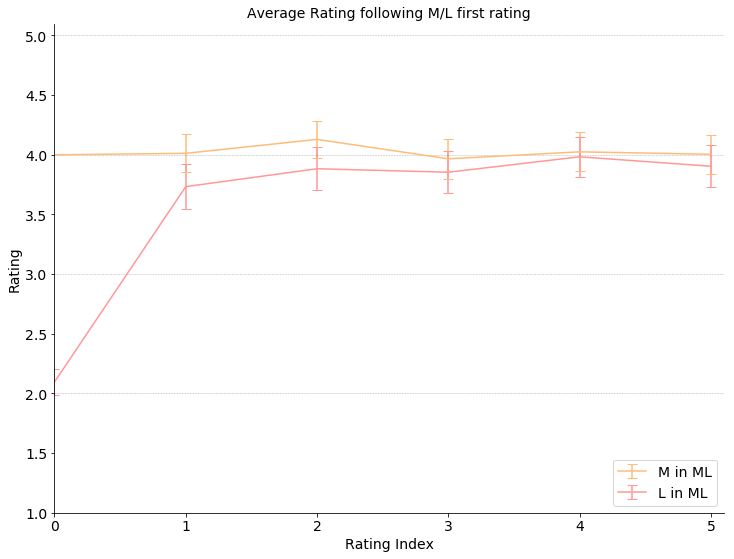

In [30]:
# herding effect on ML
result = matching_df.query('type == "ML"').apply(lambda x: find_n_reviews(x, 5, review_books_df), 1)

# create 2 5reviews df based on the result of our functions
M_in_ML_df = pd.DataFrame([x[0] for x in result])
L_in_ML_df = pd.DataFrame([x[1] for x in result])

# compute the interesting stats for each reviews
M_in_ML_stats = compute_stats_on_reviews_df(M_in_ML_df)
L_in_ML_stats = compute_stats_on_reviews_df(L_in_ML_df)

plot_stats_bar_plot('Average Rating following M/L first rating',
                    M_in_ML_stats, orange, 'M in ML', L_in_ML_stats, light_red, 'L in ML')

Here the results are more volatile as we have only arround 250 data. That being said, and the first review rating difference being higher in this group (compared to HM), we can still observe a nice herding effect on the few following ratings. Once again the effect is lowered compared to what we could observe on the HL or the extreme HL group for example.

To conclude on this part it seems that our hypothesis of herding effect is validated once again on our scaled dataset. We confirmed our hypothesis strongly on the HL and extreme HL categories and slightly on the HM and ML categories. Observing the HH, MM and LL group helped us to validate our theory on independant pairs of books. 

We can now, tell that the first review as an influence on the following reviews weigthed by the difference in the rate of the first review. We also observed that after only a few review (2 to 3 reviews) the herding effect seems to fade off and both rating converge toward a similar value.

Scaling up the data in this milestone also helped to understand and confirm some new phenomon such as the importance of the magnitude of the difference between the first review in observing the herding effect.

We are now going to check if the herding effect is really fading and converging in the next part focused on the long term effect of herding.

#### long term effect of herding on the scaled dataset

To assess the long term effect of herding, we will look at the pair of books with more than 10 reviews and compute the mean of all the reviews after that as well as it's 95% confidence interval. Then we will will compare our result for the different group we have at hand.

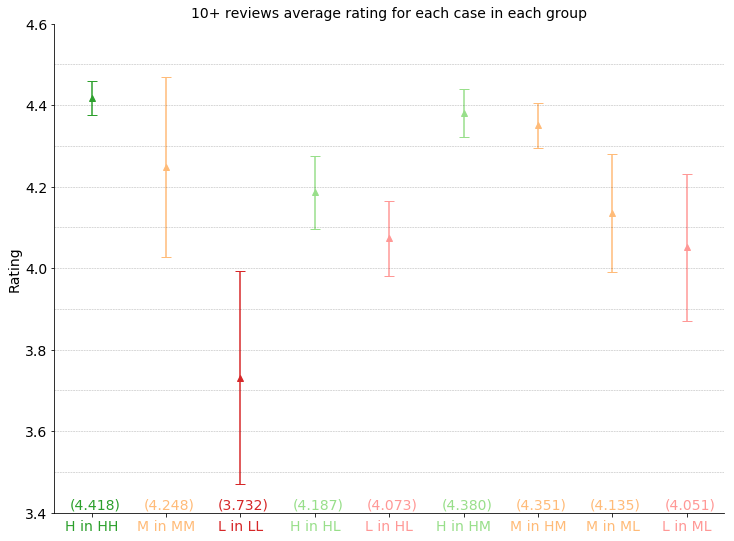

In [34]:
# find the average last reviews for each HH pairs
result = matching_df.query('type == "HH"').apply(lambda x: mean_more_n_reviews(x, 10, review_books_df), 1)
H_in_HH_df = pd.DataFrame([x[0] for x in result]).dropna().reset_index().drop(['index'], axis=1)

# find the average last reviews for each MM pairs
result = matching_df.query('type == "MM"').apply(lambda x: mean_more_n_reviews(x, 10, review_books_df), 1)
M_in_MM_df = pd.DataFrame([x[0] for x in result]).dropna().reset_index().drop(['index'], axis=1)

# find the average last reviews for each LL pairs
result = matching_df.query('type == "LL"').apply(lambda x: mean_more_n_reviews(x, 10, review_books_df), 1)
L_in_LL_df = pd.DataFrame([x[0] for x in result]).dropna().reset_index().drop(['index'], axis=1)

# find the average last reviews for each HL pairs
result = matching_df.query('type == "HL"').apply(lambda x: mean_more_n_reviews(x, 10, review_books_df), 1)
H_in_HL_df = pd.DataFrame([x[0] for x in result]).dropna().reset_index().drop(['index'], axis=1)
L_in_HL_df = pd.DataFrame([x[1] for x in result]).dropna().reset_index().drop(['index'], axis=1)

# find the average last reviews for each HM pairs
result = matching_df.query('type == "HM"').apply(lambda x: mean_more_n_reviews(x, 10, review_books_df), 1)
H_in_HM_df = pd.DataFrame([x[0] for x in result]).dropna().reset_index().drop(['index'], axis=1)
M_in_HM_df = pd.DataFrame([x[1] for x in result]).dropna().reset_index().drop(['index'], axis=1)

# find the average last reviews for each ML pairs
result = matching_df.query('type == "ML"').apply(lambda x: mean_more_n_reviews(x, 10, review_books_df), 1)
M_in_ML_df = pd.DataFrame([x[0] for x in result]).dropna().reset_index().drop(['index'], axis=1)
L_in_ML_df = pd.DataFrame([x[1] for x in result]).dropna().reset_index().drop(['index'], axis=1)



# compute mean and error for each HH books
H_in_HH_mean = np.mean(H_in_HH_df['mean'])
H_in_HH_error = error_from_interval(
    st.t.interval(0.95, len(H_in_HH_df)-1, loc=H_in_HH_mean, scale=st.sem(H_in_HH_df['mean'])))

# compute mean and error for each MM books
M_in_MM_mean = np.mean(M_in_MM_df['mean'])
M_in_MM_error = error_from_interval(
    st.t.interval(0.95, len(M_in_MM_df)-1, loc=M_in_MM_mean, scale=st.sem(M_in_MM_df['mean'])))

# compute mean and error for each LL books
L_in_LL_mean = np.mean(L_in_LL_df['mean'])
L_in_LL_error = error_from_interval(
    st.t.interval(0.95, len(L_in_LL_df)-1, loc=L_in_LL_mean, scale=st.sem(L_in_LL_df['mean'])))

# compute mean and error for each HL books
H_in_HL_mean = np.mean(H_in_HL_df['mean'])
H_in_HL_error = error_from_interval(
    st.t.interval(0.95, len(H_in_HL_df)-1, loc=H_in_HL_mean, scale=st.sem(H_in_HL_df['mean'])))

L_in_HL_mean = np.mean(L_in_HL_df['mean'])
L_in_HL_error = error_from_interval(
    st.t.interval(0.95, len(L_in_HL_df)-1, loc=L_in_HL_mean, scale=st.sem(L_in_HL_df['mean'])))

# compute mean and error for each HM books
H_in_HM_mean = np.mean(H_in_HM_df['mean'])
H_in_HM_error = error_from_interval(
    st.t.interval(0.95, len(H_in_HM_df)-1, loc=H_in_HM_mean, scale=st.sem(H_in_HM_df['mean'])))

M_in_HM_mean = np.mean(M_in_HM_df['mean'])
M_in_HM_error = error_from_interval(
    st.t.interval(0.95, len(M_in_HM_df)-1, loc=M_in_HM_mean, scale=st.sem(M_in_HM_df['mean'])))

# compute mean and error for each ML books
M_in_ML_mean = np.mean(M_in_ML_df['mean'])
M_in_ML_error = error_from_interval(
    st.t.interval(0.95, len(M_in_ML_df)-1, loc=M_in_ML_mean, scale=st.sem(M_in_ML_df['mean'])))

L_in_ML_mean = np.mean(L_in_ML_df['mean'])
L_in_ML_error = error_from_interval(
    st.t.interval(0.95, len(L_in_ML_df)-1, loc=L_in_ML_mean, scale=st.sem(L_in_ML_df['mean'])))

# finally plot our results
plot_lastreviews_means_and_errors_scaled(H_in_HH_mean, H_in_HH_error, M_in_MM_mean,
                                         M_in_MM_error, L_in_LL_mean, L_in_LL_error,
                                         H_in_HL_mean, H_in_HL_error, L_in_HL_mean,
                                         L_in_HL_error, H_in_HM_mean, H_in_HM_error,
                                         M_in_HM_mean, M_in_HM_error, M_in_ML_mean,
                                         M_in_ML_error, L_in_ML_mean, L_in_ML_error)

First thing to observe here is that: every time the first review differ (HL, HM or ML), we can observe a lower average on the lower first review. This would confirm that the herding effect through first review of a book tends to impact the whole average rating of the following reviews even after more than 10 reviews.

We also observed quiet obviously that HH and MM tends to have a higher average than their counterpart HL/HM or ML.

We can draw a similar conclusion here than for the previous milestone: even if on the previous analysis of the first 5 ratings it seemed that the rating was converging after a few reviews. We observe by deeply analysing the 10-th and above reviews that a first negative review still impact the long term rating of the product in some way. Confirming our results on more groups and with more data is once again very gratifying and confirm that our theory from previous milestone are validated.

#### Limitation of this analysis

Even though we had good results in favor of our hypothesis on herding effect on the books review on Amazon for the first few reviews following, we are aware that our analysis has some limitating factors. For example, when we matched two very similar books together, we considered that they completly identical. However some external factors may bias our analysis such as the edition, the price of the book and the type of cover as well as may other considerations that could affect the rating of the review such as the date of the review and publication of the product...